# Fixed-wake rectangular wing simulation

## 1. import required packages

In [3]:
'''Example 7 : vnv with BYU VortexLattice'''
import csdl
import numpy as np
from VAST.core.fluid_problem import FluidProblem
from VAST.utils.generate_mesh import *
from VAST.core.submodels.input_submodels.create_input_module import CreateACSatesModule
from VAST.core.vlm_llt.vlm_solver import VLMSolverModel
from python_csdl_backend import Simulator
from VAST.core.vlm_llt.vlm_dynamic_old.VLM_prescribed_wake_solver import UVLMSolver


import cProfile
profiler = cProfile.Profile()

In [4]:
def ex8_generate_model():
    fluid_problem = FluidProblem(solver_option='VLM', problem_type='prescribed_wake')

    model_1 = csdl.Model()
    ####################################################################
    # 1. add aircraft states
    ####################################################################
    num_nodes = 99;  nt = num_nodes
    n_period = 4
    omg=1
    h=0.1
    alpha = - np.deg2rad(5)

    t_vec = np.linspace(0, n_period*np.pi*2, num_nodes)

    u_val = (np.ones(num_nodes) * np.cos(alpha)).reshape((num_nodes,1))
    w_vel = np.ones((num_nodes,1)) * np.sin(alpha) - h * np.cos(omg*t_vec).reshape((num_nodes,1))

    alpha_equ = np.arctan2(w_vel, u_val)

    states_dict = {
        'u': u_val, 'v': np.zeros((num_nodes, 1)), 'w': w_vel,
        'p': np.zeros((num_nodes, 1)), 'q': np.zeros((num_nodes, 1)), 'r': np.zeros((num_nodes, 1)),
        'theta': alpha_equ, 'psi': np.zeros((num_nodes, 1)),
        'x': np.zeros((num_nodes, 1)), 'y': np.zeros((num_nodes, 1)), 'z': np.zeros((num_nodes, 1)),
        'phiw': np.zeros((num_nodes, 1)), 'gamma': np.zeros((num_nodes, 1)),'psiw': np.zeros((num_nodes, 1)),
    }

    ####################################################################
    # 2. add VLM meshes
    ####################################################################
    # single lifting surface 
    # (nx: number of points in streamwise direction; ny:number of points in spanwise direction)

    x_coords = np.loadtxt('vnv_meshes/byu_vortex_lattice/x_dynamic.txt')
    y_coords = np.loadtxt('vnv_meshes/byu_vortex_lattice/y_dynamic.txt')
    z_coords = np.loadtxt('vnv_meshes/byu_vortex_lattice/z_dynamic.txt')
    mesh = np.stack((x_coords, y_coords, z_coords), axis=-1)

    nx = x_coords.shape[0]; ny = x_coords.shape[1]

    surface_names = ['wing']
    surface_shapes = [(num_nodes, nx, ny, 3)]

    


    surface_properties_dict = {'wing':(nx,ny,3)}

    # mesh_val = generate_simple_mesh(nx, ny, num_nodes)
    mesh_val = np.zeros((num_nodes, nx, ny, 3))
    z_offset = h*sin(omg*t_vec)

    for i in range(num_nodes):
        mesh_val[i, :, :, :] = mesh
        mesh_val[i, :, :, 0] = mesh.copy()[:, :, 0] 
        mesh_val[i, :, :, 1] = mesh.copy()[:, :, 1] 
        mesh_val[i, :, :, 2] += z_offset[i]

    h_stepsize = t_vec[1] 

    ####################################################################
    # 3. add VAST solver
    ####################################################################
    if fluid_problem.solver_option == 'VLM' and fluid_problem.problem_type == 'fixed_wake':
        eval_pts_shapes = [(num_nodes, x[1] - 1, x[2] - 1, 3) for x in surface_shapes]
        wing = model_1.create_input('wing', val=np.einsum('i,jkl->ijkl', np.ones((num_nodes)), mesh))
        submodel = VLMSolverModel(
            surface_names=surface_names,
            surface_shapes=surface_shapes,
            num_nodes=num_nodes,
            eval_pts_shapes=eval_pts_shapes,
            AcStates='dummy',
        )
        model_1.add(submodel, 'VLMSolverModel')
        sim = Simulator(model_1)
    elif fluid_problem.solver_option == 'VLM' and fluid_problem.problem_type == 'prescribed_wake':
        sim = Simulator(UVLMSolver(num_times=nt,h_stepsize=h_stepsize,states_dict=states_dict,
                                        surface_properties_dict=surface_properties_dict,mesh_val=mesh_val), mode='rev')
    # wing_C_L_OAS = np.array([0.4426841725811703]).reshape((num_nodes, 1))
    # wing_C_D_i_OAS = np.array([0.005878842561184834]).reshape((num_nodes, 1))
    
    ####################################################################
    profiler.enable()
    # rep = csdl.GraphRepresentation(model_1)
    profiler.disable()
    profiler.dump_stats('output_1')
    #  # add simulator
    return sim

sim = ex8_generate_model()


sim.run()

FileNotFoundError: vnv_meshes/byu_vortex_lattice/x_dynamic.txt not found.

# Fixed-wake rectangular wing simulation

## 3. Visualizing the mesh


No module named 'trame'

Falling back to a static output.


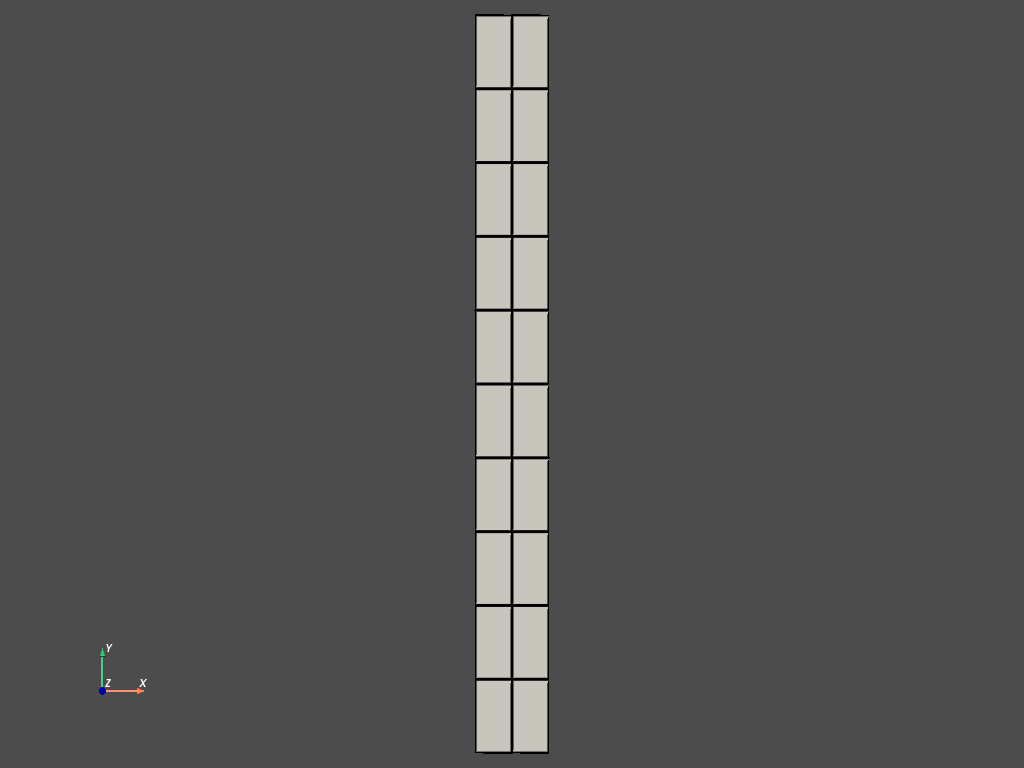

In [7]:
import pyvista as pv

mesh = sim['wing'].reshape((3,11,3))

# Create and plot structured grid
grid = pv.StructuredGrid(mesh[:,:,0], mesh[:,:,1], mesh[:,:,2])

grid.plot(show_edges=True, line_width=3, cpos="xy")


In [11]:
print('the lift coefficient is: ', sim['wing_C_L'])
print('the induced drag coefficient is: ', sim['wing_C_D_i'])

the lift coefficient is:  [[0.44526274]]
the induced drag coefficient is:  [[0.00594827]]
